In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

In [2]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder, file_name, mode, times):
    df = pd.DataFrame()
    if times>1:
        csv_files = glob.glob(path_folder + "/*.csv")
        df_list = (pd.read_csv(file) for file in csv_files)
        df   = pd.concat(df_list, ignore_index=True)
    else:
        df = pd.read_csv('{}/{}'.format(path_folder,file_name))
    df = df.fillna(0)
    df=df.rename(columns={'Plan time': 'plan_time'})
    df = df.rename(columns = {'Query Number':'query_number', 'Query Name':'query_name', 'Execution Time':'execution_time', 'Query hash':'query_hash'})
    df['query_number'] = df['query_number'].astype(int)
    df['query_hash'] = df['query_hash'].astype(str)
    df['plan_time'] = df['plan_time'].astype(float)
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df['exec_time_avg'] = df['execution_time']/times
        df['plan_time_avg'] = df['plan_time']/times
    return df

In [3]:
df_control = pd.read_csv('/home/alena/Yandex.Disk/aqo/andrew_exec_control.csv', sep='\t')

In [4]:
df_err_control = pd.read_csv('/home/alena/Yandex.Disk/aqo/andrew_err_fored.csv', sep=',')

In [5]:
df_learn = pd.read_csv('/home/alena/Yandex.Disk/aqo/andrew_exec_learn.csv', sep='\t')

In [6]:
df_err_learn = pd.read_csv('/home/alena/Yandex.Disk/aqo/andrew_err_learn.csv', sep=',')

In [7]:
df_disabled = pd.read_csv('/home/alena/Yandex.Disk/aqo/andrew_exec_disable.csv', sep='\t')

In [8]:
df = df_disabled.merge(df_control, how='left', on='query')

In [9]:
df

num  iter_x    query  exec_time_x  q_num  iter_y  exec_time_y
0      1       1  10a.sql    42833.708      1       1     2889.115
1      2       1  10b.sql     2940.675      2       1     2999.606
2      3       1  10c.sql     3382.613      3       1     3111.555
3      4       1  11a.sql    20772.012      4       1    12988.378
4      5       1  11b.sql      915.540      5       1      719.761
..   ...     ...      ...          ...    ...     ...          ...
108  109       1   8d.sql     6101.699    109       1     6100.514
109  110       1   9a.sql     4379.319    110       1     4872.541
110  111       1   9b.sql     3249.247    111       1     2862.700
111  112       1   9c.sql    17628.093    112       1     8203.608
112  113       1   9d.sql    43034.031    113       1    26601.487

[113 rows x 7 columns]

In [10]:
df['better_worse']=((df['exec_time_x']-df['exec_time_y'])/df['exec_time_x'])*100

In [11]:
lst_cond=[]
for i in df['better_worse']:
    if i < 0 and i > -10:
        lst_cond.append('df_less0_10')
    elif i <= -10 and i > -50:
        lst_cond.append('df_less10_50')
    elif i <= -50:
        lst_cond.append('df_less50_100')
    elif i >= 0 and i < 10:
        lst_cond.append('df_more0_10')
    elif i >= 10 and i < 50:
        lst_cond.append('df_more10_25')
    elif i >= 50:
        lst_cond.append('df_more50_100')

In [12]:
df['condition']=lst_cond

In [13]:
lst_groups=['df_less0_10','df_less10_50','df_less50_100', 'df_more0_10', 'df_more10_50','df_more50_100']

In [14]:
ox = df['query']

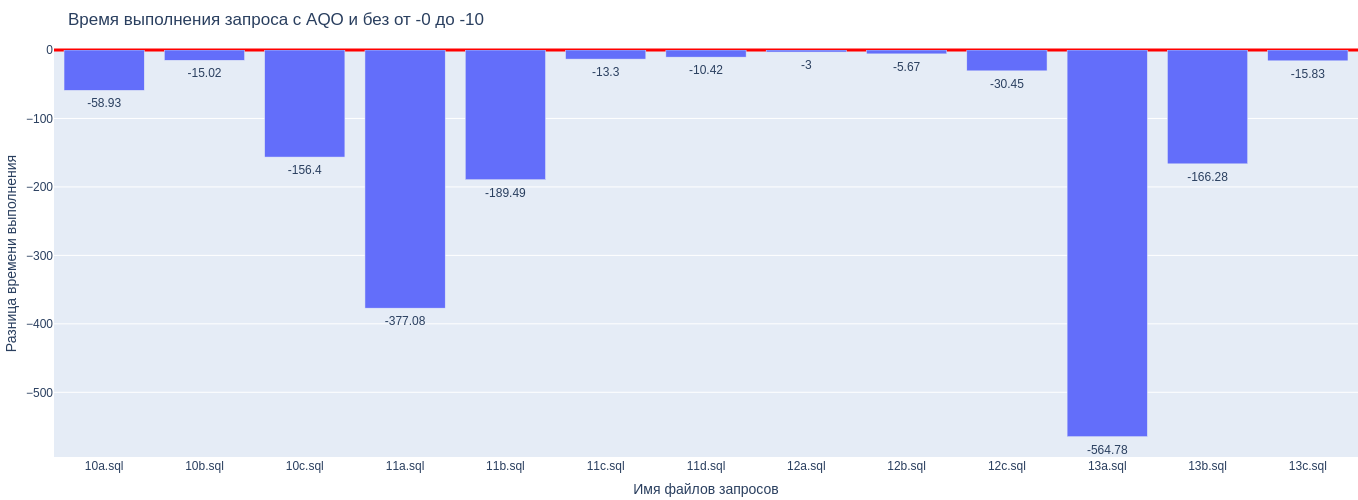

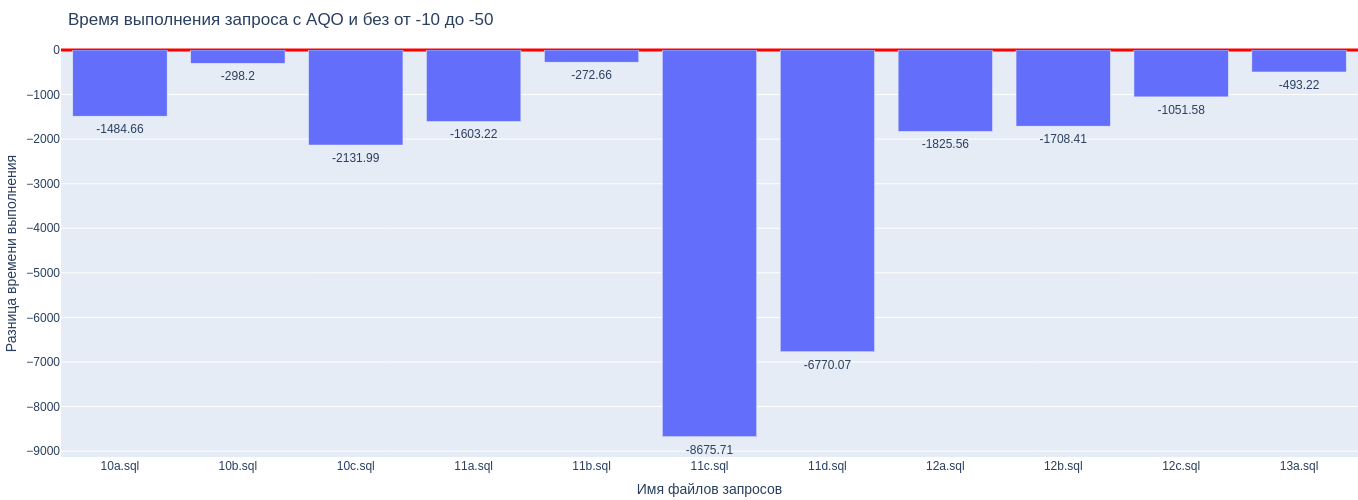

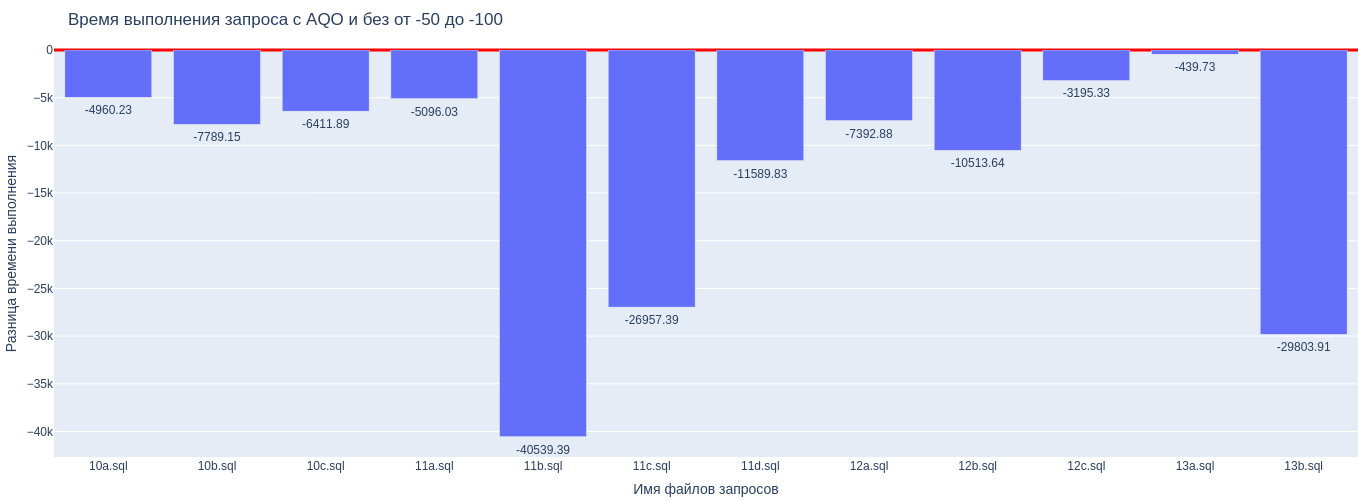

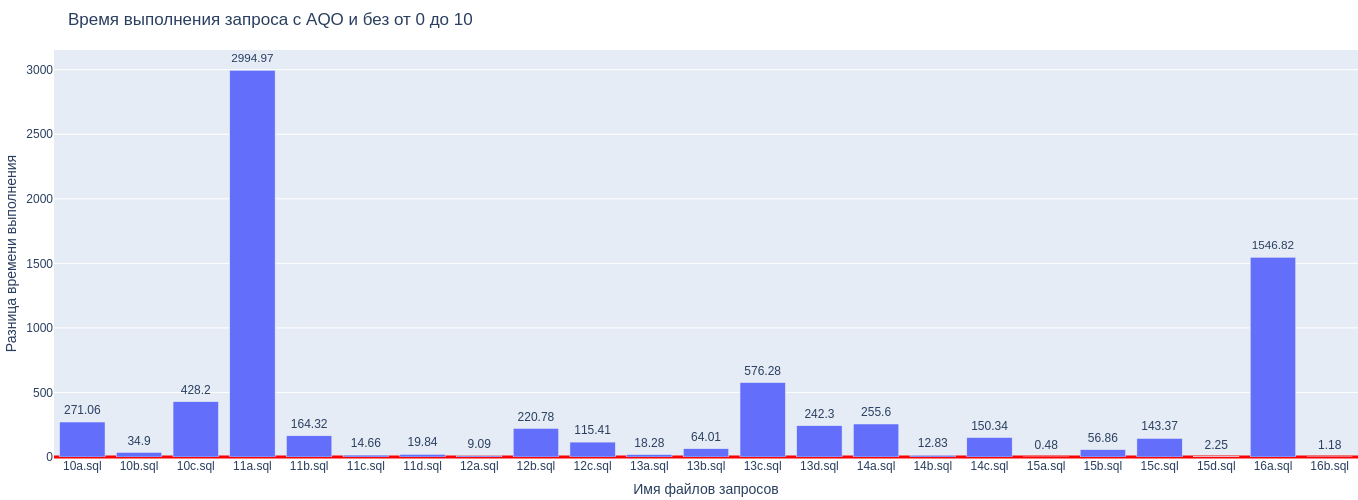

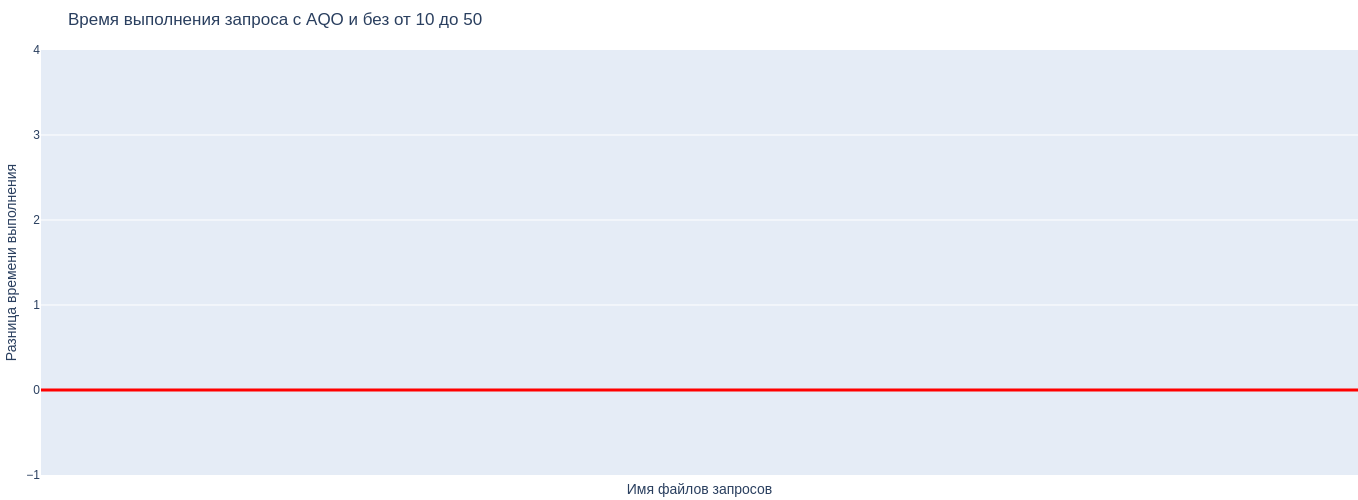

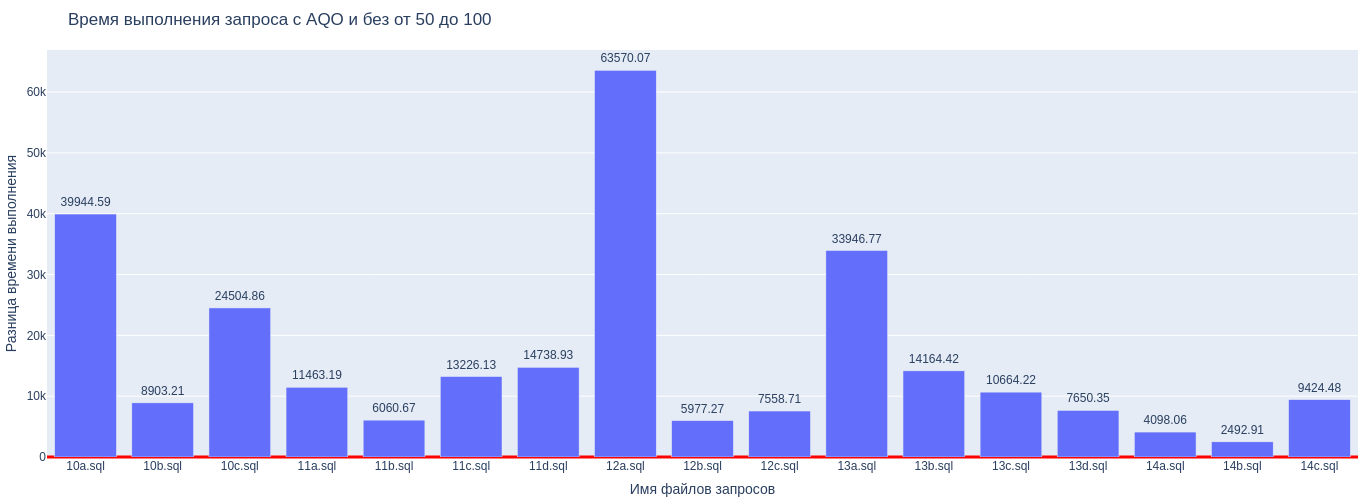

In [15]:
for elem in lst_groups:
    df_cond = df[df['condition']==elem]
    digits=re.findall(r'(\d+)', elem)
    if 'less' in elem:
        name='Время выполнения запроса с AQO и без от -{} до -{}'.format(digits[0], digits[1])
        filename='plan_less{}_{}'.format(digits[0], digits[1])
    else:
        name='Время выполнения запроса с AQO и без от {} до {}'.format(digits[0], digits[1])
        filename='plan_more{}_{}'.format(digits[0], digits[1])
    fig = go.Figure()
    fig.add_trace(go.Bar(x = ox, y = df_cond['exec_time_x'] - df_cond['exec_time_y'], text=round(df_cond['exec_time_x'] - df_cond['exec_time_y'],2), textposition='outside'))
    fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      title=name,
                      xaxis_title="Имя файлов запросов",
                      yaxis_title="Разница времени выполнения",
                      margin=dict(l=0, r=0, t=50, b=0))
    fig.update_layout(width=1500, height = 500)
    fig.show()

In [16]:
df_err_control.columns=['id','errdelta']
df_err_learn.columns=['id','errdelta']

In [17]:
df_err_learn['id'] = df_err_learn['id'].astype(str)
df_err_control['id'] = df_err_control['id'].astype(str)

In [18]:
df = df_err_learn.merge(df_err_control, how='left', on='id')

некорректно, нужен disabled

In [19]:
query_id=df_learn['query'].unique()

In [20]:
df_learn

query_num  iter    query  exec_time
0             1     1  10a.sql   3242.918
1             1     2  10a.sql   3156.190
2             1     3  10a.sql   2965.295
3             1     4  10a.sql   2974.461
4             1     5  10a.sql   2975.880
...         ...   ...      ...        ...
1125        113     6   9d.sql   8012.894
1126        113     7   9d.sql   5912.238
1127        113     8   9d.sql   7306.709
1128        113     9   9d.sql   6862.871
1129        113    10   9d.sql   7693.669

[1130 rows x 4 columns]

In [22]:
for i in query_id:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = ox, y = df[df['id'==i]])
    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, y = 0.4, xanchor="center"),
                      title="Во сколько раз время планирования запроса с AQO превосходит без AQO",
                      xaxis_title="Имя файлов запросов",
                      yaxis_title="Значение",
                      margin=dict(l=0, r=0, t=50, b=0))
    fig.update_layout(width=3000, height = 1200)
    fig.show()

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1993164278.py, line 3)

In [23]:
df_stat = pd.read_csv('/home/alena/Downloads/Telegram Desktop/aqo_query_stat.csv')

In [24]:
df_stat

queryid                            execution_time_with_aqo  \
0    7524898333597169082  {1.407534604,13.281387701,0.831999634,2.466131...   
1    6753536170651198495  {10.91643344,22.975707035,28.635149827,7.94746...   
2   -2528685657720903448  {2.520282029,2.292986388,2.3061944309999998,2....   
3   -7161925776851004507  {2.080550243,1.911063173,1.909551275,1.9046160...   
4   -6884649069187808611  {42.144018535,7.104630066,477.997659616,187.26...   
..                   ...                                                ...   
193  5681998567155226962  {17.399649892,0.744602694,0.795805985,0.742328...   
194 -3136445610191114428  {18.752346561,17.937582054,5.540738118,5.61042...   
195 -2185514600278022665  {13.562329168,5.493299184,7.87534699,5.4680844...   
196  5381223619302321231  {5.751592699,5.125743035,4.967167135,5.3639536...   
197  5677290187950113934  {2.635616982,2.585766076,2.766453991,3.0274061...   

    execution_time_without_aqo  \
0                {1.064182387}   
1               {11.516026476}   
2                {2.487874582}   
3                {1.988001166}   
4               {54.094199027}   
..                         ...   
193             {21.524688625}   
194             {11.052437552}   
195             {15.537835285}   
196              {7.036789379}   
197              {2.868368355}   

                                planning_time_with_aqo  \
0    {2.763125691,2.702292416,2.729777294,2.7090999...   
1    {0.013660406,0.013317952,0.013511271,0.0134530...   
2    {2.286112026,2.30446828,2.281406639,2.26623023...   
3    {0.059508162,0.059948325,0.060506039,0.0608109...   
4    {0.097869285,0.027133777,0.027425851,0.0359989...   
..                                                 ...   
193  {0.145935841,0.03019029,0.030348559,0.03032013...   
194  {0.326939338,0.138036571,0.139341625,0.1425143...   
195  {0.018260614,0.018816778,0.018712589,0.0186596...   
196  {2.569469361,2.582430428,2.589552119,2.5580676...   
197  {3.390604057,3.381090223,3.369075649,3.3915536...   

    planning_time_without_aqo  \
0               {0.118541168}   
1                {0.00538026}   
2               {0.098009884}   
3               {0.017193437}   
4               {0.055321052}   
..                        ...   
193             {0.204598455}   
194             {0.267506124}   
195             {0.006111988}   
196             {0.098486066}   
197             {0.111734981}   

                            cardinality_error_with_aqo  \
0    {1.3968210228925457,1.3161189206349808,0.44083...   
1    {2.8825893169756225,1.750364137202322,1.461632...   
2    {1.5787663532914025,0.8143393693333846,0.00453...   
3    {1.8858465747467388,0.4572069209482909,0.21107...   
4    {2.813246318852216,1.8636470442239081,1.180783...   
..                                                 ...   
193  {2.2174581788074854,0.767081186461634,1.180739...   
194  {1.9887324457065196,1.3517577990977008,0.81003...   
195  {2.4414999421171997,0.651502106188795,0.949805...   
196  {1.3475933906074387,1.4856236999565589,0.57539...   
197  {2.3958030244276123,1.4655829233990951,1.07846...   

    cardinality_error_without_aqo  executions_with_aqo  executions_without_aqo  
0            {1.3800087198410513}                   10                       1  
1            {2.8825893169756225}                   10                       1  
2            {1.5722655961114913}                   10                       1  
3              {1.87772062827185}                   10                       1  
4             {2.804217489435673}                   10                       1  
..                            ...                  ...                     ...  
193          {2.2270181158367666}                   10                       1  
194          {1.9732544524210174}                   10                       1  
195           {2.421185075929978}                   10                       1  
196          {1.3345918762476165}                   10    

In [25]:
lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
       'planning_time_with_aqo', 'planning_time_without_aqo',
       'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
lst_stat_cut = [1, 1, 1, 1, 1, 1]

In [26]:
df_stat = get_preprocess_dataframe(df_stat, lst_stat_columns, lst_stat_cut)

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [27]:
lst_min_val_with_aqo = []
lst_min_iter_with_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.cardinality_error_with_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
            break
    lst_min_val_with_aqo.append(min_val)
    lst_min_iter_with_aqo.append(iteration)

In [28]:
df_stat['min_iter_card_with'] = lst_min_iter_with_aqo

In [29]:
df_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo

In [30]:
df_stat['min_iter_card_with']

0      6
1      3
2      2
3      4
4      7
      ..
193    3
194   -1
195    3
196   -1
197   -1
Name: min_iter_card_with, Length: 198, dtype: int64

In [31]:
len(df_stat[df_stat['min_iter_card_with']==-1])

64

In [32]:
len(df_stat[df_stat['min_iter_card_with']>-1])

134

In [33]:
oy=['not derived less error with 0.1','derived less error with 0.1']
ox=[len(df_stat[df_stat['min_iter_card_with']==-1]),len(df_stat[df_stat['min_iter_card_with']>-1])]

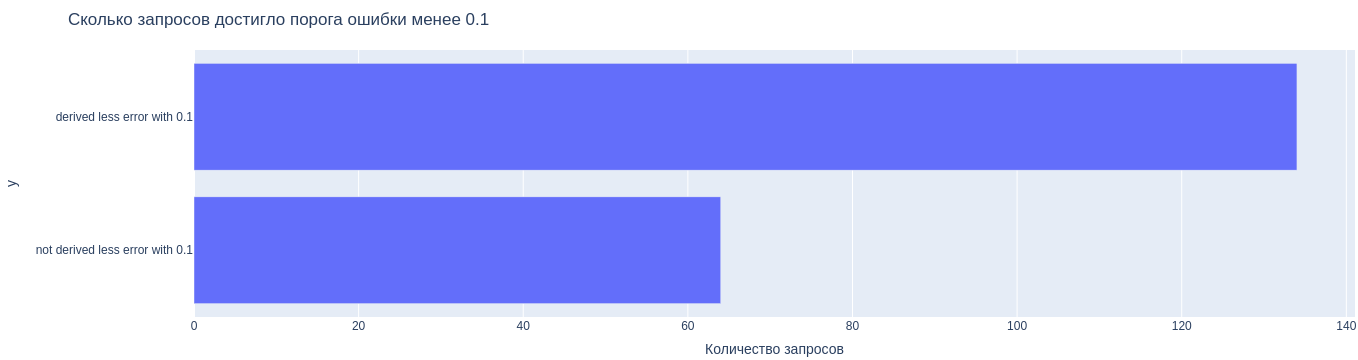

In [34]:
fig = px.bar(x=ox, y=oy)
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="Сколько запросов достигло порога ошибки менее 0.1",
                  xaxis_title="Количество запросов",
                  margin=dict(l=0, r=0, t=50, b=0))

In [35]:
lst_min_val_without_aqo = []
lst_min_iter_without_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.cardinality_error_without_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_without_aqo.append(min_val)
    lst_min_iter_without_aqo.append(iteration)

In [36]:
df_stat['min_iter_card_without'] = lst_min_iter_without_aqo

In [37]:
df_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

In [38]:
len(df_stat[df_stat['min_iter_card_without']==-1])

198

In [39]:
len(df_stat[df_stat['min_iter_card_without']>-1])

0

In [40]:
x = np.array(range(20))

In [41]:
lst_min_val_with_aqo = []
lst_min_iter_with_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.execution_time_with_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_with_aqo.append(min_val)
    lst_min_iter_with_aqo.append(iteration)

In [42]:
df_stat['min_iter_exec_with'] = lst_min_iter_with_aqo

In [43]:
df_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

In [44]:
df_stat['min_iter_exec_with']

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
193   -1
194   -1
195   -1
196   -1
197   -1
Name: min_iter_exec_with, Length: 198, dtype: int64

In [45]:
len(df_stat[df_stat['min_iter_exec_with']==-1])

180

In [46]:
len(df_stat[df_stat['min_iter_exec_with']>-1])

18

In [47]:
lst_min_val_without_aqo = []
lst_min_iter_without_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.execution_time_without_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_without_aqo.append(min_val)
    lst_min_iter_without_aqo.append(iteration)

In [48]:
df_stat['min_iter_exec_without'] = lst_min_iter_without_aqo

In [49]:
df_stat['lst_min_exec_without_aqo'] = lst_min_val_without_aqo

In [50]:
df_stat['queryid'] = df_stat['queryid'].astype(str)

In [51]:
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   queryid                              198 non-null    object 
 1   cardinality_error_without_aqo_split  198 non-null    object 
 2   cardinality_error_with_aqo_split     198 non-null    object 
 3   planning_time_without_aqo_split      198 non-null    object 
 4   planning_time_with_aqo_split         198 non-null    object 
 5   execution_time_without_aqo_split     198 non-null    object 
 6   execution_time_with_aqo_split        198 non-null    object 
 7   executions_with_aqo                  198 non-null    int64  
 8   executions_without_aqo               198 non-null    int64  
 9   min_iter_card_with                   198 non-null    int64  
 10  lst_min_val_with_aqo                 198 non-null    float64
 11  min_iter_card_without           

In [52]:
ox = df_stat['queryid'].to_list()
oy = df_stat['min_iter_card_with'].to_list()

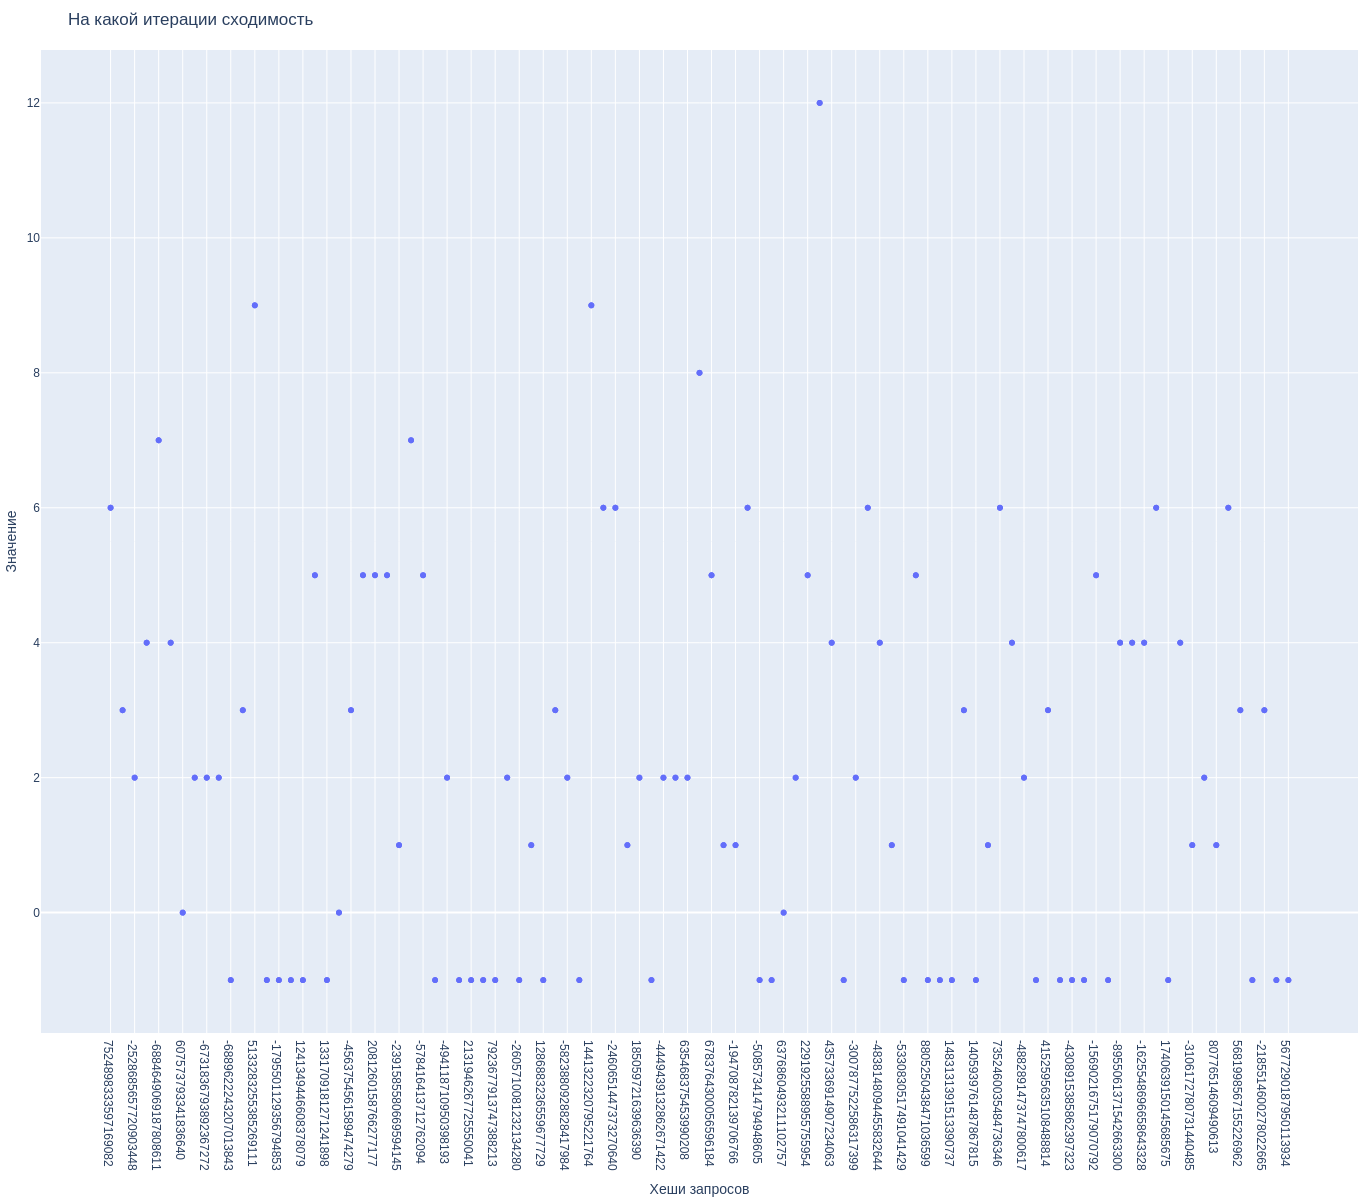

In [53]:
fig = go.Figure()
fig = px.scatter(df_stat, y='min_iter_card_with', x='queryid')
#fig.add_trace(go.Scatter(x = ox, y = [-1]*len(df_stat['min_iter_card_with'])))
#fig.add_trace(go.Scatter(x = ox, y = [1]*len(df_stat['min_iter_card_with'])))
#fig.add_trace(go.Scatter(x = ox, y = [3]*len(df_stat['min_iter_card_with'])))
#fig.add_trace(go.Scatter(x = ox, y = [5]*len(df_stat['min_iter_card_with'])))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="На какой итерации сходимость",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

In [54]:
df_stat_sum = df_stat.copy()

In [55]:
lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']

In [56]:
lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']

In [57]:
lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']

In [58]:
for i in lst_columns:
    df_stat_sum = functions.last_errors(df_stat, i)

In [59]:
for i in lst_columns_with:
    df_stat_sum = functions.sum_errors(df_stat, i)

In [60]:
for i in lst_columns_without:
    df_stat_sum = functions.sum_errors(df_stat, i)

In [61]:
df_stat_sum

queryid  cardinality_error_without_aqo_split  \
0     7524898333597169082                             1.380009   
1     6753536170651198495                             2.882589   
2    -2528685657720903448                             1.572266   
3    -7161925776851004507                             1.877721   
4    -6884649069187808611                             2.804217   
..                    ...                                  ...   
193   5681998567155226962                             2.227018   
194  -3136445610191114428                             1.973254   
195  -2185514600278022665                             2.421185   
196   5381223619302321231                             1.334592   
197   5677290187950113934                             2.384595   

     cardinality_error_with_aqo_split  planning_time_without_aqo_split  \
0                            0.000000                         0.118541   
1                            0.007361                         0.005380   
2                            0.004530                         0.098010   
3                            0.011157                         0.017193   
4                            0.010129                         0.055321   
..                                ...                              ...   
193                          0.006544                         0.204598   
194                          0.968083                         0.267506   
195                          0.019903                         0.006112   
196                          0.761604                         0.098486   
197                          0.820531                         0.111735   

     planning_time_with_aqo_split  execution_time_without_aqo_split  \
0                       27.192281                          1.064182   
1                        0.134837                         11.516026   
2                       22.866848                          2.487875   
3                        0.606270                          1.988001   
4                        0.355628                         54.094199   
..                            ...                               ...   
193                      0.417106                         21.524689   
194                      1.595720                         11.052438   
195                      0.185161                         15.537835   
196                     25.822679                          7.036789   
197                     33.809485                          2.868368   

     execution_time_with_aqo_split  executions_with_aqo  \
0                        23.112705                   10   
1                       118.240695                   10   
2                        23.136302                   10   
3                        19.272839                   10   
4                      1088.185218                   10   
..                             ...                  ...   
193                      24.150633                   10   
194                      98.261959                   10   
195                      65.221505                   10   
196                      52.157082                   10   
197                      27.231434                   10   

     executions_without_aqo  min_iter_card_with  lst_min_val_with_aqo  \
0                         1                   6              0.097385   
1                         1                   3              0.021513   
2                         1                   2              0.004530   
3                         1                   4              0.029170   
4                         1                   7              0.010129   
..                      ...                 ...                   ...   
193                       1                   3              0.041960   
194                       1                  -1         100000.000000   
195                       1                   3              0.019903   
196                       1                 

In [62]:
for i in lst_columns_with:
    df_stat_sum[i] = df_stat_sum[i] / df_stat_sum['executions_with_aqo']

In [63]:
for i in lst_columns_without:
    df_stat_sum[i] = df_stat_sum[i] / df_stat_sum['executions_without_aqo']

In [64]:
df_stat_sum

queryid  cardinality_error_without_aqo_split  \
0     7524898333597169082                             1.380009   
1     6753536170651198495                             2.882589   
2    -2528685657720903448                             1.572266   
3    -7161925776851004507                             1.877721   
4    -6884649069187808611                             2.804217   
..                    ...                                  ...   
193   5681998567155226962                             2.227018   
194  -3136445610191114428                             1.973254   
195  -2185514600278022665                             2.421185   
196   5381223619302321231                             1.334592   
197   5677290187950113934                             2.384595   

     cardinality_error_with_aqo_split  planning_time_without_aqo_split  \
0                            0.000000                         0.118541   
1                            0.007361                         0.005380   
2                            0.004530                         0.098010   
3                            0.011157                         0.017193   
4                            0.010129                         0.055321   
..                                ...                              ...   
193                          0.006544                         0.204598   
194                          0.968083                         0.267506   
195                          0.019903                         0.006112   
196                          0.761604                         0.098486   
197                          0.820531                         0.111735   

     planning_time_with_aqo_split  execution_time_without_aqo_split  \
0                        2.719228                          1.064182   
1                        0.013484                         11.516026   
2                        2.286685                          2.487875   
3                        0.060627                          1.988001   
4                        0.035563                         54.094199   
..                            ...                               ...   
193                      0.041711                         21.524689   
194                      0.159572                         11.052438   
195                      0.018516                         15.537835   
196                      2.582268                          7.036789   
197                      3.380948                          2.868368   

     execution_time_with_aqo_split  executions_with_aqo  \
0                         2.311270                   10   
1                        11.824069                   10   
2                         2.313630                   10   
3                         1.927284                   10   
4                       108.818522                   10   
..                             ...                  ...   
193                       2.415063                   10   
194                       9.826196                   10   
195                       6.522151                   10   
196                       5.215708                   10   
197                       2.723143                   10   

     executions_without_aqo  min_iter_card_with  lst_min_val_with_aqo  \
0                         1                   6              0.097385   
1                         1                   3              0.021513   
2                         1                   2              0.004530   
3                         1                   4              0.029170   
4                         1                   7              0.010129   
..                      ...                 ...                   ...   
193                       1                   3              0.041960   
194                       1                  -1         100000.000000   
195                       1                   3              0.019903   
196                       1                 

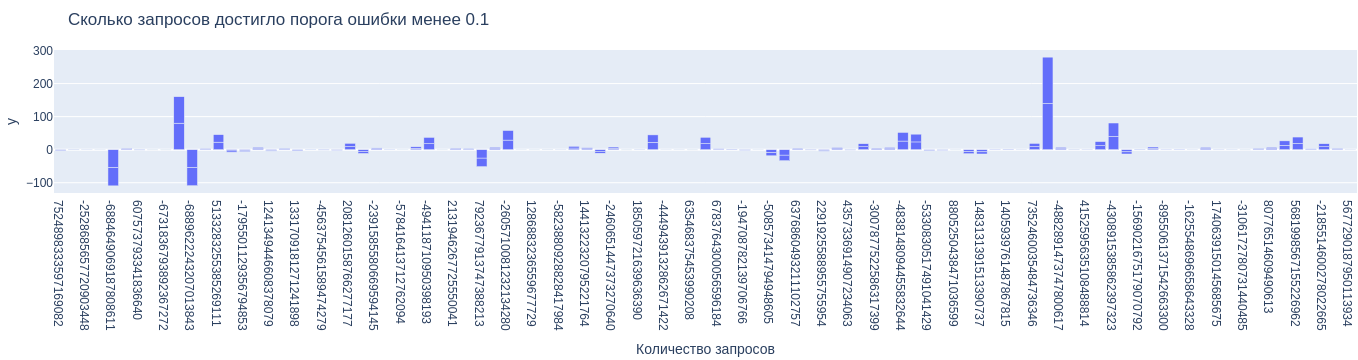

In [96]:
fig = px.bar(x=df_stat_sum['queryid'], y=(df_stat_sum['execution_time_without_aqo_split']-df_stat_sum['execution_time_with_aqo_split']))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="Сколько запросов достигло порога ошибки менее 0.1",
                  xaxis_title="Количество запросов",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.show()

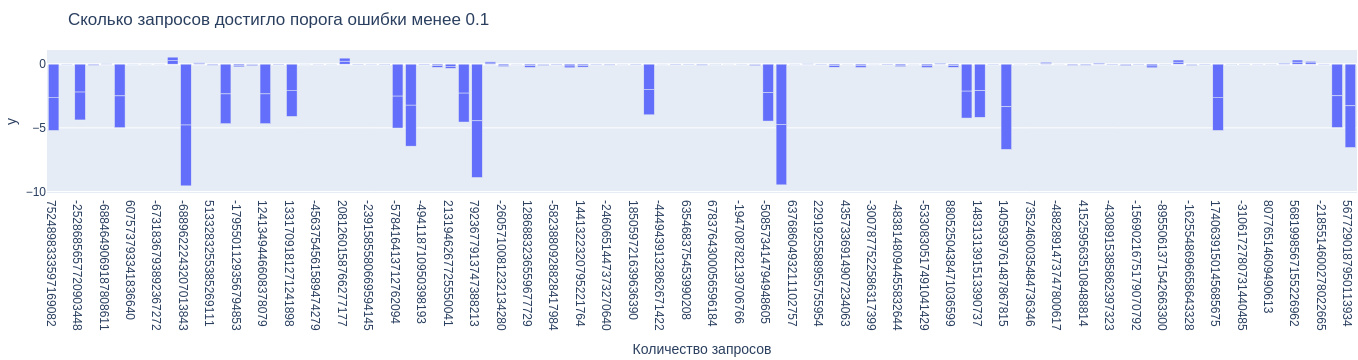

In [97]:
fig = px.bar(x=df_stat_sum['queryid'], y=(df_stat_sum['planning_time_without_aqo_split']-df_stat_sum['planning_time_with_aqo_split']))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="Сколько запросов достигло порога ошибки менее 0.1",
                  xaxis_title="Количество запросов",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.show()

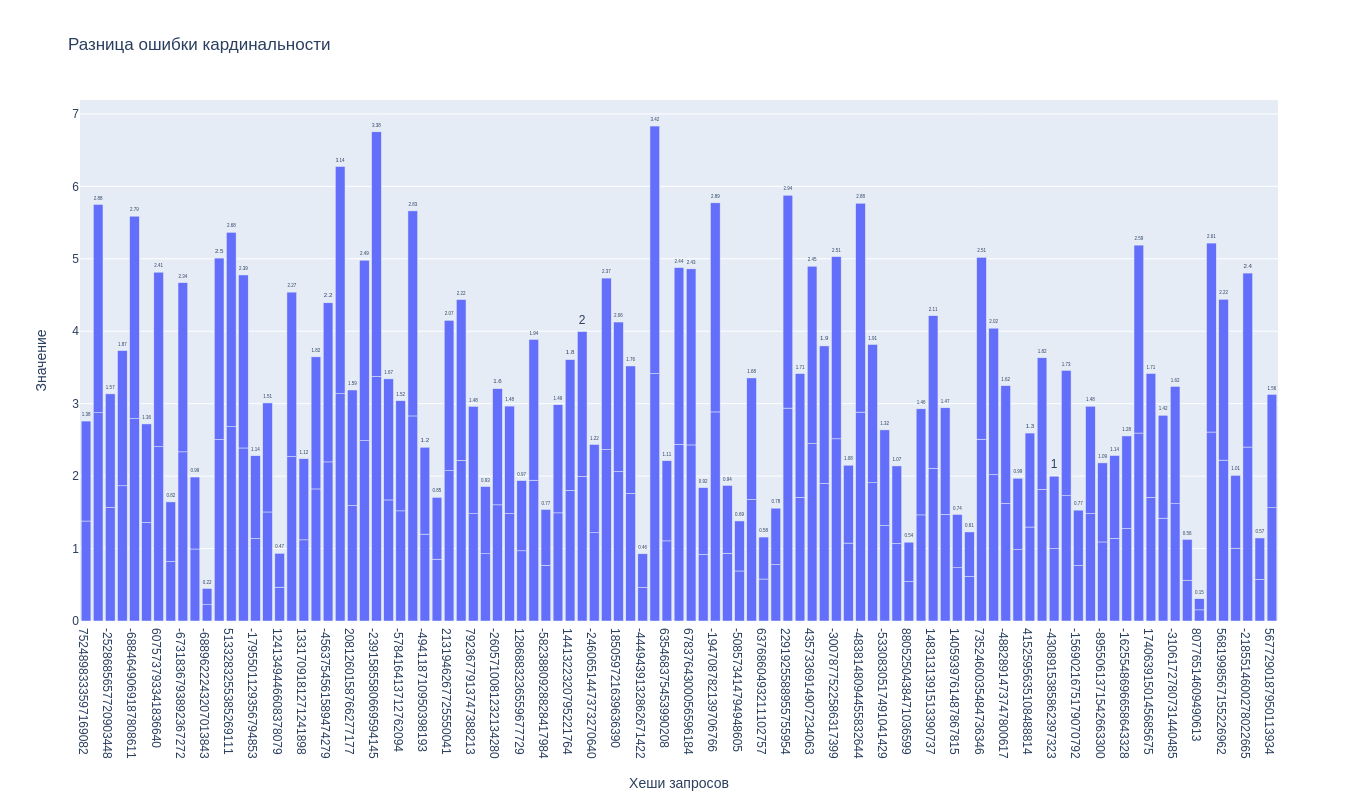

In [71]:
fig = go.Figure()
fig.add_trace(go.Bar(name = 'without AQO', x=df_stat_sum['queryid'], y=(df_stat_sum['cardinality_error_without_aqo_split']-df_stat_sum['cardinality_error_with_aqo_split']),
                    text=round((df_stat_sum['cardinality_error_without_aqo_split']-df_stat_sum['cardinality_error_with_aqo_split']),2), textposition='outside'))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [3]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Bar(name='with AQO', x=df_stat_sum['queryid'], y=df_stat_sum['cardinality_error_with_aqo_split'],
#                    text=round(df_stat_sum['cardinality_error_without_aqo_split'],2), textposition='outside'))
fig.update_layout(width=3000, height = 800, title="Разница ошибки кардинальности",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()

In [72]:
df_stat_sum_0_3=df_stat_sum[(df_stat_sum['execution_time_without_aqo_split']-df_stat_sum['execution_time_with_aqo_split']<3)]

In [89]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = df_stat_sum['execution_time_without_aqo_split']-df_stat_sum['execution_time_with_aqo_split']))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-1]*len(df_stat_sum_0_3['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [1]*len(df_stat_sum_0_3['cardinality_error_without_aqo_split'])))
fig=px.histogram(df_stat_sum, x='query_id', y='execution_time_without_aqo_split')
fig.update_layout(width=3000, height = 800, title="Ошибка во времени выполнения запросов",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['queryid', 'cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split', 'planning_time_with_aqo_split', 'execution_time_without_aqo_split', 'execution_time_with_aqo_split', 'executions_with_aqo', 'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo', 'min_iter_card_without', 'lst_min_val_without_aqo', 'min_iter_exec_with', 'lst_min_exec_with_aqo', 'min_iter_exec_without', 'lst_min_exec_without_aqo'] but received: query_id

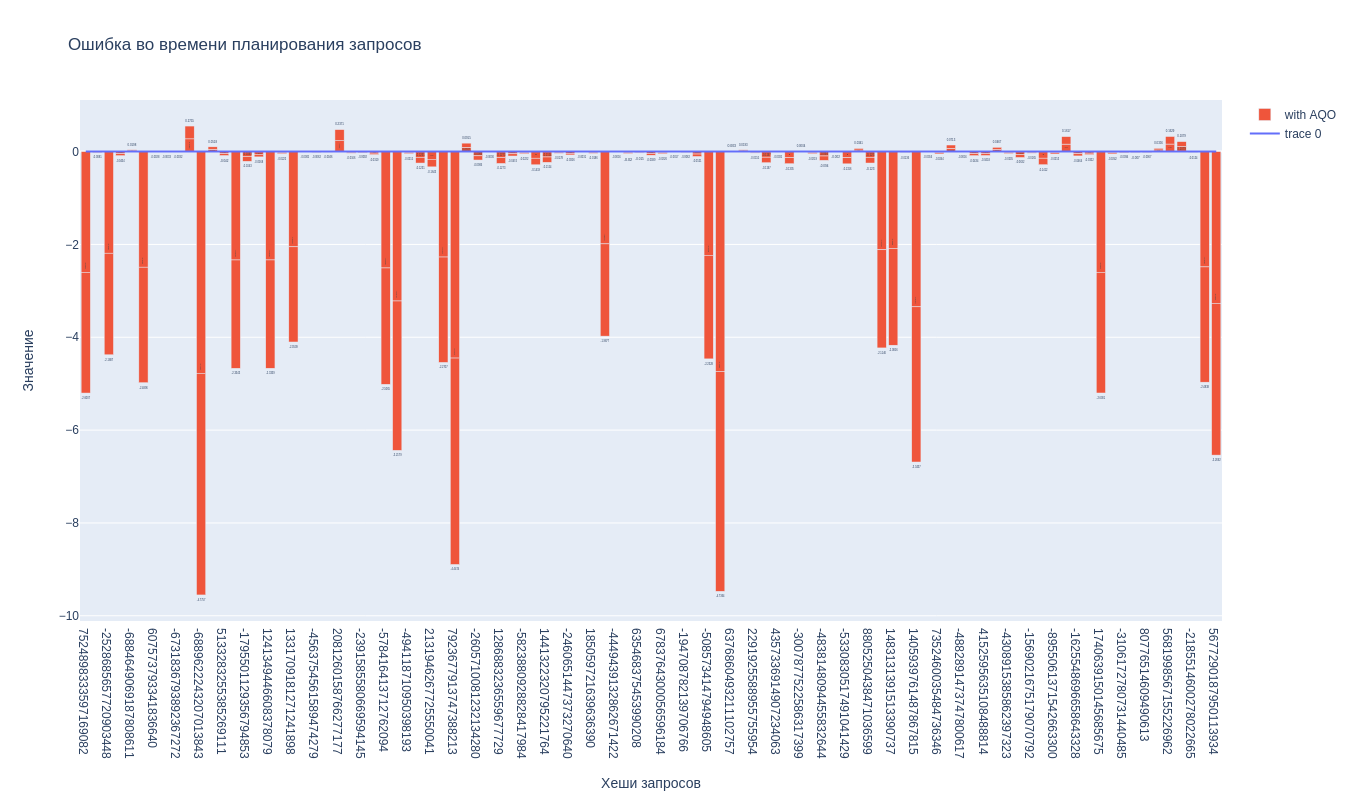

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [0]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-0.1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [0]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Bar(name='with AQO', x=df_stat_sum['queryid'], y=df_stat_sum['planning_time_without_aqo_split']-df_stat_sum['planning_time_with_aqo_split'],
                    text=round(df_stat_sum['planning_time_without_aqo_split']-df_stat_sum['planning_time_with_aqo_split'],4), textposition='outside'))
fig.update_layout(barmode='stack', width=3000, height = 800, title="Ошибка во времени планирования запросов",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()